To open on Google Colab\
https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week3/linear_kinetic_models.ipynb

In [34]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

import matplotlib 
import matplotlib.pyplot as plt

## Regression model to predict ```logP``` (*lipophilicity*)

* ```logP``` is one of the most used observalbes in drug design. 
* It measures how much of a solute dissolves in the water portion versus an organic portion.
* $\log P < 0$, the compound has a higher affinity for the aqueous phase.
* $\log P > 0$, higher concentration in the lipid phase.
* $\log P = 0$, the compound is equally partitioned between the lipid and aqueous phases.

**Drug Discovery**\
```logP``` is used in the pharmaceutical/biotech industries to understand the behavior of drug molecules in the body. Drug candidates are often screened according to ```logP```, among other criteria, to help guide drug selection and analog optimization. This is because lipophilicity is a major determining factor in a
compound’s absorption, distribution in the body, penetration across vital membranes and biological barriers, metabolism and excretion. 


**Reference**:\
[**link**](https://www.acdlabs.com/wp-content/uploads/download/app/physchem/making_sense.pdf)

## Example
[**paper**](https://doi.org/10.1016/S0960-894X(03)00656-5)\
[**example**](https://kbbox.h-its.org/toolbox/tutorials/data-exploration-and-linear-regression-of-a-kinetic-dataset-using-r/)\
[**cross-validation**](https://scikit-learn.org/stable/modules/cross_validation.html)

data set,
```python
data_url = 'https://kbbox.h-its.org/media/uploads/2017/11/15/map38.csv' 
```

In [17]:
#load data
data_url = 'https://kbbox.h-its.org/media/uploads/2017/11/15/map38.csv'
data = pd.read_csv(data_url)

# * Print the name of the columns in the file
columns_names = data.columns
print(columns_names)

Index(['compound_key', 'pKD', 'pkon', 'pkoff', 'vsa_positiv', 'vsa_negativ',
       'lipophilicity', 'vsa_polar', 'weight'],
      dtype='object')


In [18]:
y = data['lipophilicity'].to_numpy()
X = data.drop(['compound_key', 'lipophilicity'],axis=1).to_numpy()
print('Data dimensions: ',X.shape)

# split training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


Data dimensions:  (16, 7)


### Models

In [24]:
def linear_model_solver(data, deg, l):
    X, y = data
    poly = PolynomialFeatures(deg)
    # X = x[np.newaxis].T  # resize to (N,d)
    Phi = poly.fit_transform(X)    
    Phit_Phi = Phi.T @ Phi
    Phit_y = Phi.T @ y

    lambda_I = l*np.eye(Phit_Phi.shape[0])  # regularization

    A = Phit_Phi + lambda_I
    A_inv = np.linalg.inv(A)
    w = A_inv @ Phit_y
    return w


In [26]:
def f_poly(X, w, deg):
    poly = PolynomialFeatures(deg)
        
    Phi = poly.fit_transform(X)
    y_pred = Phi @ w
    return y_pred

In [32]:
def f_rmse(y_true, y_pred):
    z = (y_true - y_pred)**2
    return np.sqrt(np.mean(z))


In [72]:
data = (X_train,y_train)
data_val = (X_val,y_val)
deg = 2
# l_ = np.array([0.,1E-4,1E-3,1E-2,1E-1,1.])
l_ = np.exp(np.linspace(-6.,0,10))
l_ = np.sort(np.append(l_,0.))

rmse_ = []
for l in l_:
    w = linear_model_solver(data,deg,l)
    y_val_pred = f_poly(X_val,w,deg)
    rmse = f_rmse(y_val,y_val_pred)
    print('l =  %.6f, rmse = %.3f '%(l,rmse))
    rmse_.append(rmse)


l =  0.000000, rmse = 23.148 
l =  0.002479, rmse = 2.289 
l =  0.004828, rmse = 2.309 
l =  0.009404, rmse = 2.293 
l =  0.018316, rmse = 2.279 
l =  0.035674, rmse = 2.288 
l =  0.069483, rmse = 2.284 
l =  0.135335, rmse = 2.284 
l =  0.263597, rmse = 2.283 
l =  0.513417, rmse = 2.283 
l =  1.000000, rmse = 2.283 


/var/folders/t5/4s883lqs43gbc9km4ykw_y7w0000gn/T/ipykernel_38265/853279423.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(l_),rmse_,ms=8,marker='o')


Text(0.5, 0, '$\\log(\\lambda)$')

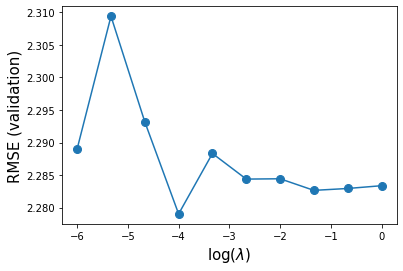

In [73]:
plt.figure(0)
plt.plot(np.log(l_),rmse_,ms=8,marker='o')

lambda_ticks = [r'$0$', r'$10^{-4}$', r'$10^{-3}$',
                r'$10^{-2}$', r'$10^{-1}$', r'$10^{1}$']
# plt.xticks(np.arange(len(l_)),lambda_ticks)
plt.ylabel('RMSE (validation)',fontsize=15)
plt.xlabel(r'$\log(\lambda)$',fontsize=15)
# plt.xlim(-0.1,1.1)

## K-fold cross validation
![k-fold]([Figures/](https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/grid_search_cross_validation.png))

In [59]:
kf = KFold(n_splits=5)
for train, val in kf.split(X):
    X_train, y_train = X[train],y[train]
    X_val, y_val = X[val],y[val]
    

[[  7.8   -4.4    3.4  371.93 190.94 180.42 543.67]
 [  7.64  -5.16   2.48 357.09 125.24 170.62 451.57]
 [  8.96  -4.33   4.64 388.84 162.14 153.06 528.66]
 [  8.6   -4.4    4.21 392.64 192.25 193.75 571.68]
 [  8.32  -3.9    4.42 459.19 173.13 207.05 584.77]
 [  7.8   -3.2    4.59 431.91 183.17 207.05 570.74]
 [  7.66  -4.87   2.8  216.91 165.91  57.94 348.45]
 [  8.96  -5.05   3.92 229.85 190.42  57.94 398.51]
 [  8.92  -4.27   4.64 372.19 182.88 129.92 525.7 ]
 [  6.52  -4.11   2.41 356.72 158.66 147.38 477.61]
 [  8.03  -4.56   3.47 271.84 180.67  85.44 428.54]
 [  7.85  -4.03   3.82 411.65 173.42 174.88 557.7 ]] [3.74 2.99 3.87 4.66 5.03 4.73 4.33 5.55 5.69 3.72 5.58 4.69] [[ 10.01  -4.93   5.08 369.66 183.17 147.38 527.67]
 [  5.92  -5.07   0.85 204.59 125.31  81.18 306.8 ]
 [ 10.01  -5.19   4.82 342.38 193.22 147.38 513.64]
 [  8.23  -4.81   3.42 315.11 193.22 147.38 499.61]] [4.94 2.97 4.64 4.29]
[[ 10.01  -4.93   5.08 369.66 183.17 147.38 527.67]
 [  5.92  -5.07   0.85 204.59 